# Data Science Project: Sentiment Analysis

**Dataset:**https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/data
**Project Overview:**
   - Sentiment Analysis is a data science project that involves the use of machine learning techniques to analyze and classify textual data based on the sentiment expressed. The project aims to build a predictive model capable of determining whether a given text conveys positive, negative, or neutral sentiment.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

import re

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from string import punctuation


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
# Load the data
df = pd.read_csv("D:/Projects/Sentiment Analysis/Dataset/training.1600000.processed.noemoticon.csv",
                 encoding='ISO-8859-1')
df.columns = ['sentiment', 'id', 'date', 'query', 'user','text']
df.sample(4)

,sentiment,id,date,query,user,text
777236,0,2322369244,Wed Jun 24 22:29:57 PDT 2009,NO_QUERY,GirlShortie,@THE_REAL_SHAQ
39175,0,1573467959,Tue Apr 21 01:18:38 PDT 2009,NO_QUERY,sniborno,Twitter is on the news
165077,0,1960610649,Fri May 29 08:13:55 PDT 2009,NO_QUERY,meetmeinmontauc,for all the effort and time put into some of t...
603712,0,2221733600,Thu Jun 18 05:54:57 PDT 2009,NO_QUERY,jsfoxton,@aurumarum awww it says not found 404! can yo...


In [4]:
df.shape

(1048572, 6)

In [5]:
df.isna().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

In [6]:
df['sentiment'].value_counts()

0    799996
4    248576
Name: sentiment, dtype: int64

In [7]:
# Map the polarity to binary values (0 for negative, 1 for positive)
df['sentiment'] = df['sentiment'].replace({4:1})

In [8]:
df['sentiment'].value_counts()

0    799996
1    248576
Name: sentiment, dtype: int64

## Cleaning and Preprocessing

In [9]:
print("12:- ",df.loc[12,'text'])
print('2459:- ',df.loc[2459,'text'])
print('52:- ',df.loc[52,'text'])
print('2250:- ',df.loc[2250,'text'])
print('4726:- ',df.loc[4726,'text'])
print('8880:- ',df.loc[8880,'text'])
print('1223:- ',df.loc[1223,'text'])
print('882861 :- ',df.loc[882861,'text'])

12:-  Hollis' death scene will hurt me severely to watch on film  wry is directors cut not out now?
2459:-  ...but first the other workathlon: 3 sets of management accounts one after the other. 
52:-  @oanhLove I hate when that happens... 
2250:-  Gnite twitter world..long day tomorrow. Night class till 10pm 
4726:-  Oh and forgot to mention. I have no voice. 
8880:-  @nick_carter Honey what I must do for you tell me &quot;HI&quot; &quot;Hello&quot; ?? Signs of smoke? I will cry    :_(
1223:-  haha I've been with my grandma for 2 days. even she's about 5 houses away, I'll still miss her 
882861 :-  @ronni_xo aww ): i had to fight my dad for the tv, and won, lol. i love having 2 tvs 


## Pre-processing

In [10]:
# Remove punctuations
df["text_no_punc"] = df["text"].apply(lambda s: ' '.join(re.sub("[%$.,!?:;()-='...@#_*&]", " ", s).split()))

In [11]:
# Remove numbers
df["text_n"]=df["text_no_punc"].replace('\d+', '', regex=True)

In [12]:
# Remove Emojis
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
df["text_npe"] = df["text_n"].apply(lambda s: deEmojify(s))

In [13]:
# Define stopwords(common words that do not add much information to the text)
remove_words = set(stopwords.words('english'))
print(remove_words)

{'don', 'do', 'or', 'who', 'aren', 'has', 'yours', 'than', 'over', 'same', 'above', 'that', 'which', 'after', 'with', 'how', 'nor', 'from', 'until', 'ourselves', 'down', 'a', 'before', 'haven', 'too', 'when', 'd', 'should', "you've", 'yourself', 'where', 'couldn', 't', 'but', 'against', 'other', 'only', 'shan', 'can', 'through', 'each', 'had', 'its', 'for', 'most', 'my', 'these', "you're", 'needn', 'myself', 'hadn', 'hasn', 'our', 'the', "shouldn't", 'again', "she's", 'hers', 'at', 'an', 'some', 'won', 'doing', 've', 'here', 'does', "couldn't", 'whom', 'by', "that'll", 'any', 'it', 'you', 'her', 'weren', 'she', 'between', 'll', 'few', 'been', 'during', 'did', 'wouldn', 'such', 'your', 'up', 'theirs', 'we', 'to', 'are', 'himself', 'why', "isn't", 'under', 'mustn', "you'll", 'into', 'was', "weren't", 'so', 'itself', "shan't", "haven't", 'there', 'own', 'not', 'wasn', 'm', "wouldn't", 'doesn', 'isn', 'now', 'o', "aren't", 'both', 'very', "hadn't", 'having', "wasn't", 'while', 'below', "wo

In [14]:
# Add custom stopwords specific to the data
add_stop_words = ['place', 'hmm','get','go','http','im','u','lol','back',
                  'going','still','one','today','day','got','oh','http','see',
                  'com','hey','many','quot','really','know','amp','well',
                  'much','want','tomorrow','facebook','update','also',
                  'r','might']+list(punctuation)
stop_words = remove_words.union(add_stop_words)

In [15]:
#Remove stopwords
def rem_en(input_txt):
    words = input_txt.lower().split()
    noise_free_words = [word for word in words if word not in stop_words] 
    noise_free_text = " ".join(noise_free_words) 
    return noise_free_text

df["text_npes"] = df["text_npe"].apply(lambda s: rem_en(s))

In [16]:
# Tokenize
from nltk.tokenize import RegexpTokenizer
tokeniser = RegexpTokenizer(r'\w+')
df["text_T"] = df["text_npes"].apply(lambda x: tokeniser.tokenize(x))

In [17]:
# Lemmatization
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()
df["text_L"] = df["text_T"].apply(lambda tokens: [lemmatiser.lemmatize(token, pos='a') for token in tokens])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
df["text_S"] = df["text_T"].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

In [19]:
df.sample(4)

,sentiment,id,date,query,user,text,text_no_punc,text_n,text_npe,text_npes,text_T,text_L,text_S
45194,0,1677087533,Sat May 02 00:24:20 PDT 2009,NO_QUERY,HeiressD,"Just saw the movie wolvarine, I deff enjoyed i...",Just saw the movie wolvarine I deff enjoyed it...,Just saw the movie wolvarine I deff enjoyed it...,Just saw the movie wolvarine I deff enjoyed it...,saw movie wolvarine deff enjoyed suggest every...,"[saw, movie, wolvarine, deff, enjoyed, suggest...","[saw, movie, wolvarine, deff, enjoyed, suggest...","[saw, movi, wolvarin, deff, enjoy, suggest, ev..."
731946,0,2263955705,Sun Jun 21 02:19:17 PDT 2009,NO_QUERY,sophiemostly,@hisforhome good luck with your sourdough star...,hisforhome good luck with your sourdough start...,hisforhome good luck with your sourdough start...,hisforhome good luck with your sourdough start...,hisforhome good luck sourdough starter ashamed...,"[hisforhome, good, luck, sourdough, starter, a...","[hisforhome, good, luck, sourdough, starter, a...","[hisforhom, good, luck, sourdough, starter, as..."
199712,0,1971501965,Sat May 30 07:15:30 PDT 2009,NO_QUERY,Keith_mark,Wishes he was at the Royal show,Wishes he was at the Royal show,Wishes he was at the Royal show,Wishes he was at the Royal show,wishes royal show,"[wishes, royal, show]","[wishes, royal, show]","[wish, royal, show]"
154978,0,1936070182,Wed May 27 07:24:03 PDT 2009,NO_QUERY,EmmieFromAbove,Walking home- alannah and i are sad cause rehe...,Walking home alannah and i are sad cause rehea...,Walking home alannah and i are sad cause rehea...,Walking home alannah and i are sad cause rehea...,walking home alannah sad cause rehearsal cance...,"[walking, home, alannah, sad, cause, rehearsal...","[walking, home, alannah, sad, cause, rehearsal...","[walk, home, alannah, sad, caus, rehears, cancel]"


## Exploratory Data Analysis(EDA)

In [20]:
# Storing positive data seperately
pos_text = df['text_npes'].loc[df['sentiment']==1]
positive_list = pos_text.tolist()

In [21]:
# Storing negative data seperately
neg_text = df['text_npes'].loc[df['sentiment']==0]
negative_list = neg_text.tolist()

In [22]:
positive_all = " ".join([word for sent in positive_list for word in sent ])
negative_all = " ".join([word for sent in negative_list for word in sent ])

## Visualization

<Axes: xlabel='keywords', ylabel='counts'>

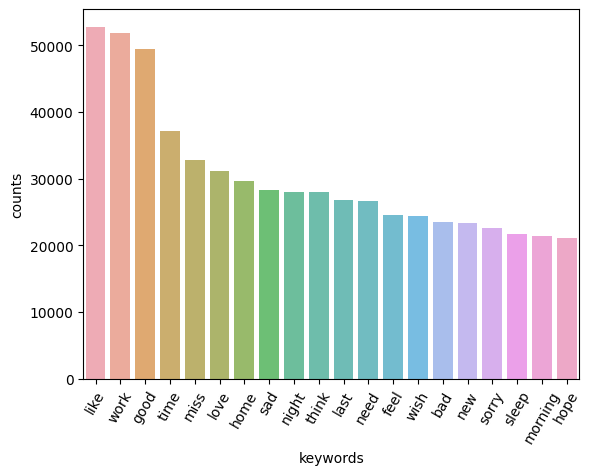

In [23]:
# find 20 most frequent words
vc = df.text_npes.str.split(expand=True).stack().value_counts().head(20)
vc_df = vc.rename_axis('Keywords').to_frame('counts')

plt.xticks(rotation=60)
sns.barplot(x=vc_df.index, y=vc_df['counts'], alpha=0.8)

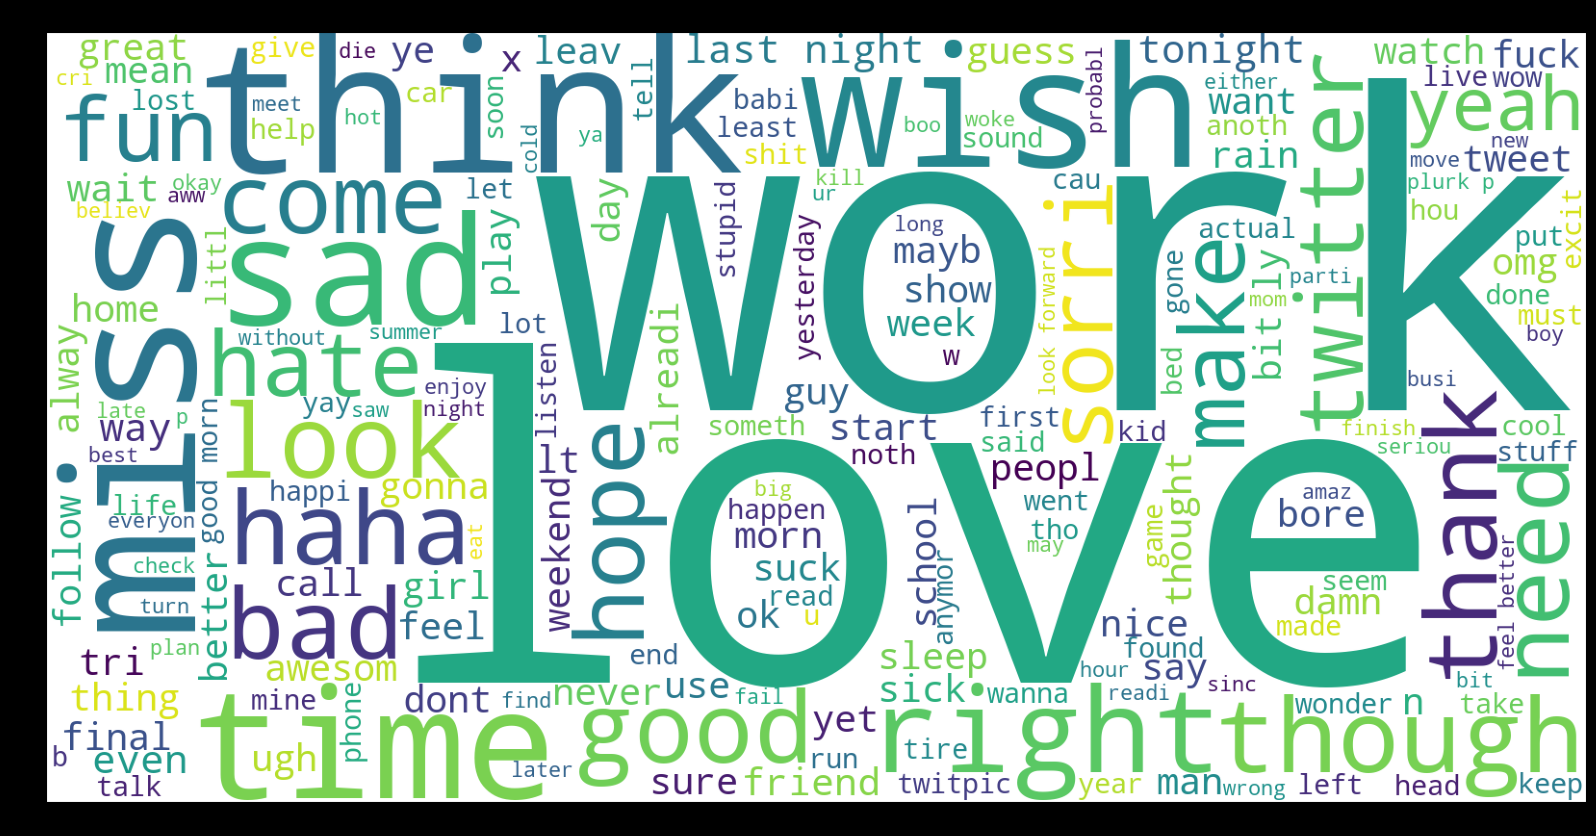

In [24]:
# generate wordcloud of the data
df['liststring'] = df['text_S'].apply(' '.join)
wordcloud = WordCloud(background_color="white",width=1600,
                      height=800).generate(' '.join(df['liststring']))
plt.figure( figsize=(20,10), facecolor='k')

plt.imshow(wordcloud)
plt.title('WordCloud of Complete data')
plt.show()

>**`Afinn` class**
The Afinn class in the Afinn library is used to instantiate an Afinn object, which can then be used to calculate sentiment scores for text. 
- from afinn import Afinn
- afn = Afinn()
>**find sentiment scores**
- df['sentiment_scores'] = data['text_npes'].apply(lambda x: afn.score(x))
>**classify reviews as positive/negative/neutral**
- df['sentiment'] = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in data['sentiment_scores']]

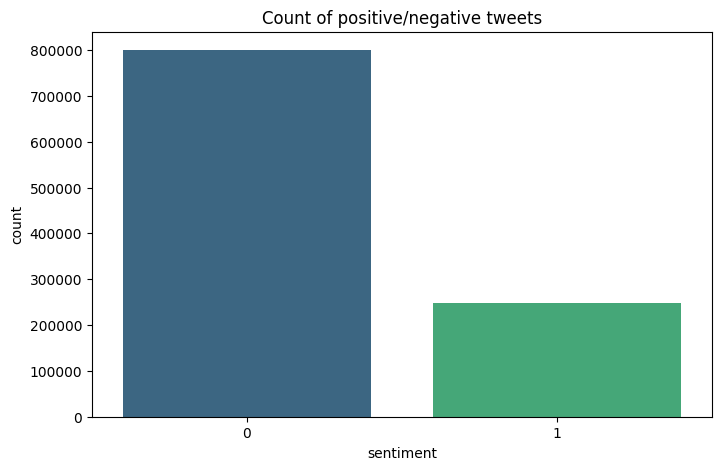

In [25]:
# Count of positive/negative/neutral tweets
plt.figure(figsize=(8,5))
fc = sns.countplot(x='sentiment', 
                    data=df, 
                    palette='viridis')
plt.title('Count of positive/negative tweets')
plt.show()

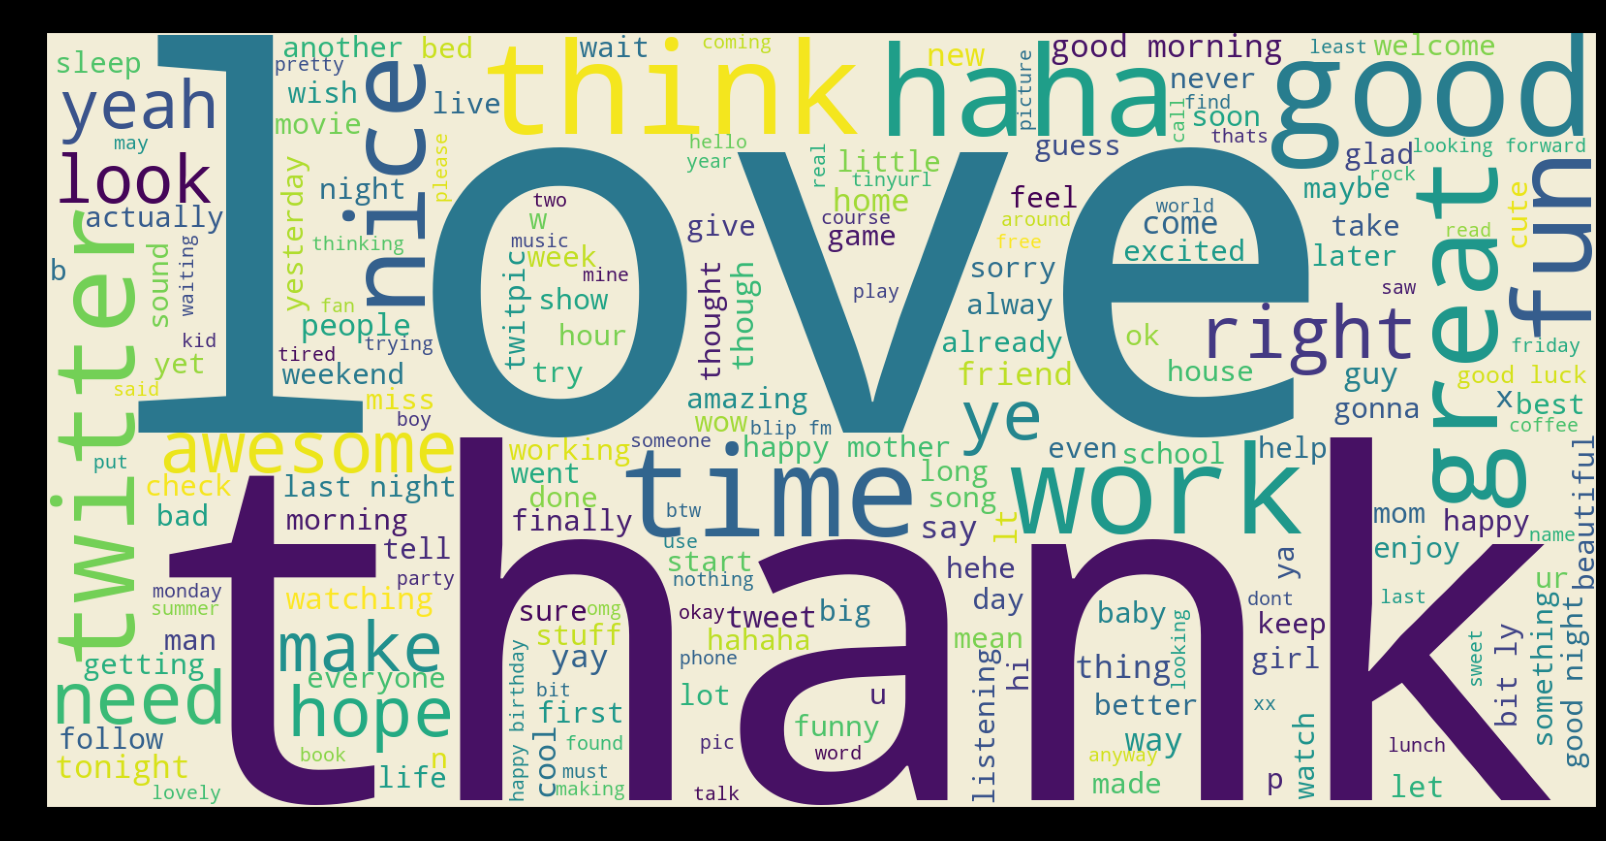

In [26]:
# wordcloud for positive tweets
wordcloud = WordCloud(background_color='#F2EDD7FF',
                      width=1600,
                      height=800).generate(' '.join(pos_text))
plt.figure( figsize=(20,30), facecolor='k')
plt.imshow(wordcloud)
plt.title('Positive Tweets')
plt.show()

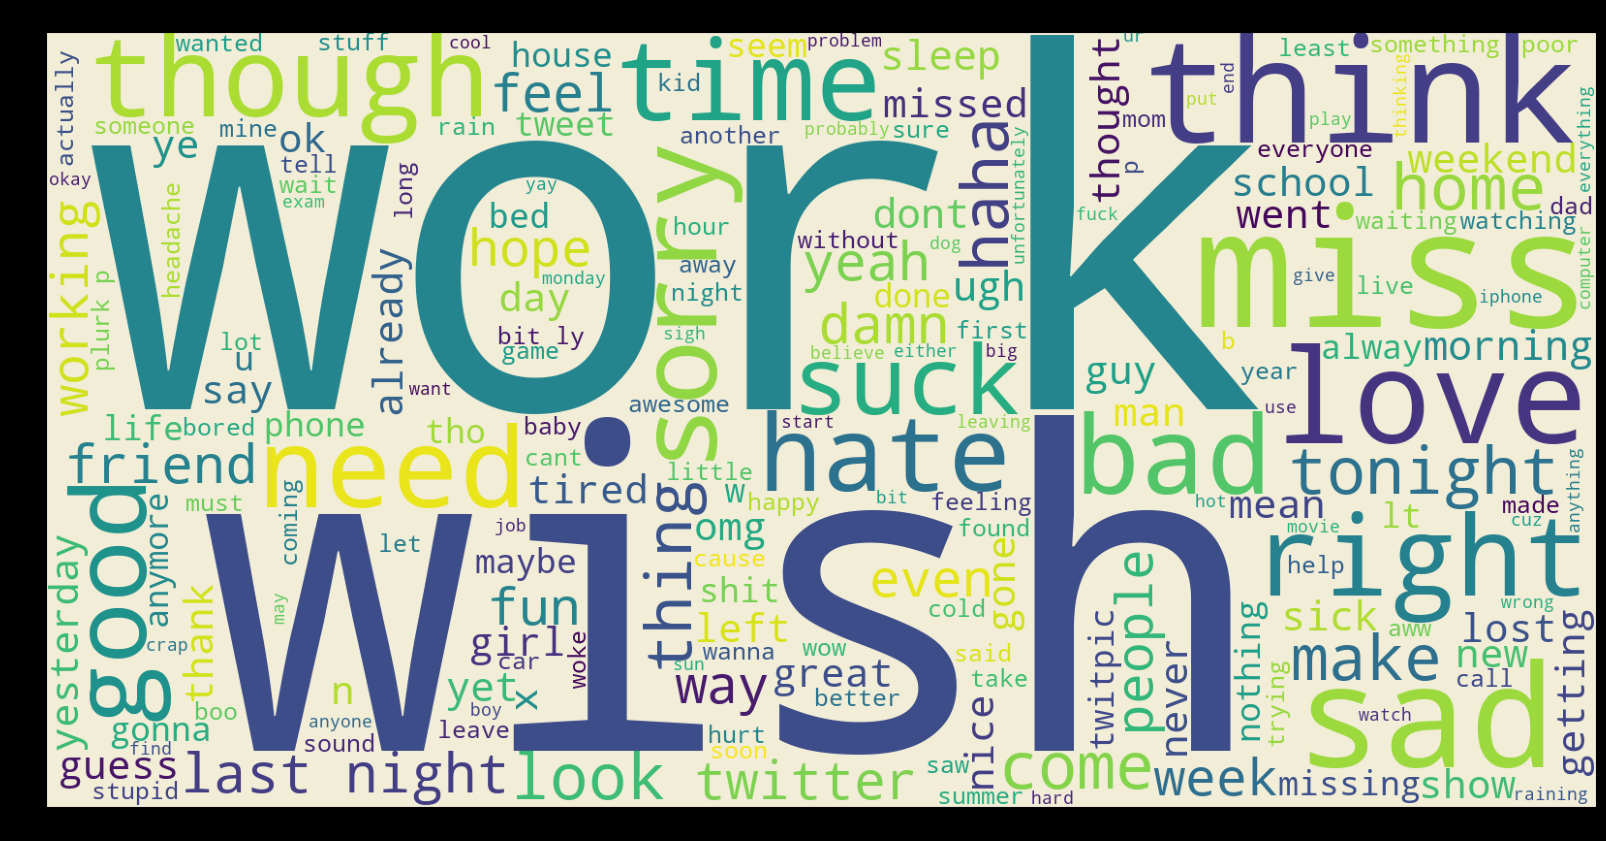

In [27]:
# wordcloud for negative reviews
wordcloud = WordCloud(background_color='#F2EDD7FF',
                      width=1600,
                      height=800).generate(' '.join(neg_text))
plt.figure( figsize=(20,30), facecolor='k')
plt.imshow(wordcloud)
plt.title('Negative Tweets')

plt.show()

In [28]:
# find 5 worst and best 5 reviews
worst_5=df.sort_values(by=['sentiment']).head(5)
best_5=df.sort_values(by=['sentiment']).tail(5)

In [29]:
#print best and worrst reviews
print("WORST REVIEWS\n", worst_5['text'])
print("\nBEST REVIEWS\n", best_5['text'])

WORST REVIEWS
 0         is upset that he can't update his Facebook by ...
533326                      Nose filled with ick is no fun 
533327                         I just wanna sleep so badly 
533328    Okay I lost everyone on my buddylist.. Does an...
533329                  i am extreeeemely lost without him 
Name: text, dtype: object

BEST REVIEWS
 882859                            naww i love you too angie 
882860             waiting for my basketball game to start. 
882861     @ronni_xo aww ): i had to fight my dad for the...
882833     @timjamesedwards you're a crackup. Question pl...
1048571                 cant wait til her date this weekend 
Name: text, dtype: object


In [30]:
from nltk import bigrams
from collections import Counter

from nltk.tokenize import word_tokenize
from nltk import bigrams
from collections import Counter

# Tokenize the text into words
words = word_tokenize(positive_list[0])  # Assuming you want to tokenize the first element of the 'text' column

# Create bigrams
bi_grams = list(bigrams(words))

# Print the bigrams`
print(bi_grams)


[('love', 'health'), ('health', 'uandpets'), ('uandpets', 'guys'), ('guys', 'best')]


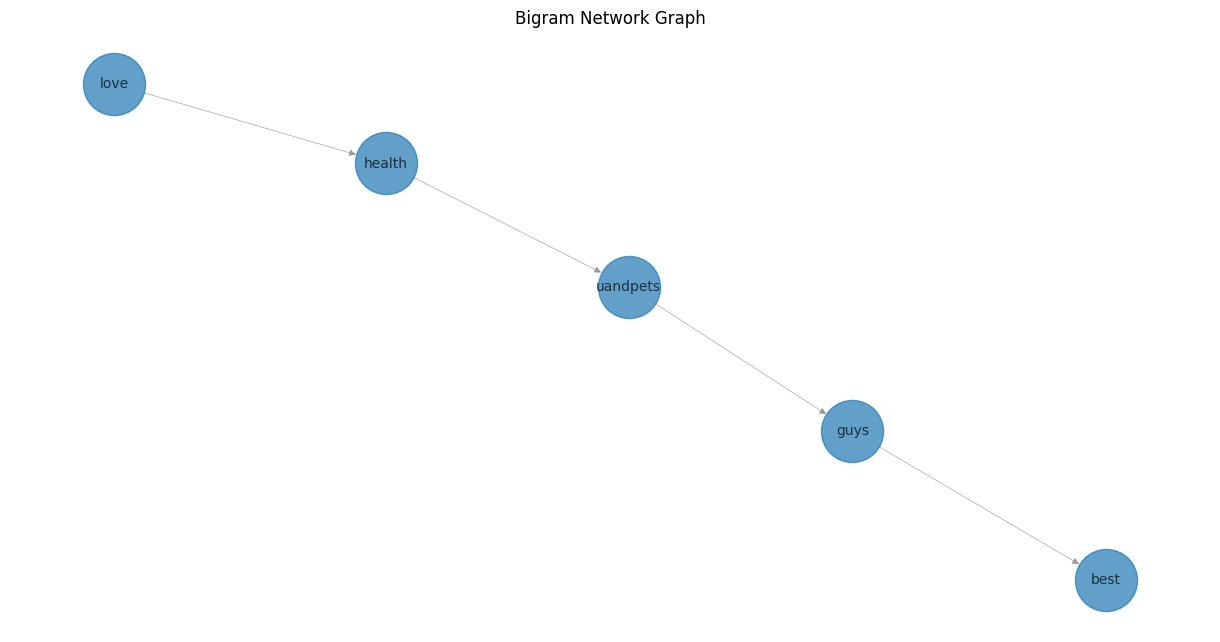

In [31]:
import networkx as nx
from nltk import bigrams
from collections import Counter

# Tokenize the text into words
words = word_tokenize(positive_list[0])

# Create bigrams
bi_grams = list(bigrams(words))

# Count the frequency of each bigram
bigram_freq = Counter(bi_grams)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for bigram, freq in bigram_freq.items():
    G.add_edge(bigram[0], bigram[1], weight=freq)

# Draw the graph
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, edge_color='gray', width=0.5, alpha=0.7)
plt.title('Bigram Network Graph')
plt.show()


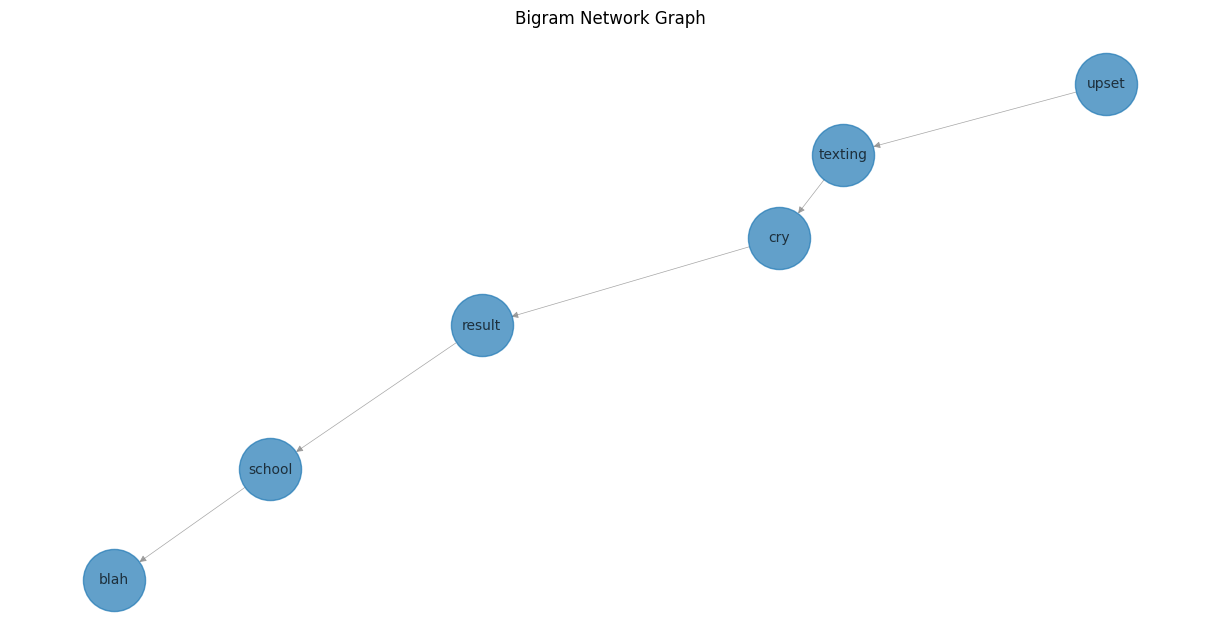

In [32]:
import networkx as nx
from nltk import bigrams
from collections import Counter

# Tokenize the text into words
words = word_tokenize(negative_list[0])  # Assuming you want to tokenize the first element of the 'text' column

# Create bigrams
bi_grams = list(bigrams(words))

# Count the frequency of each bigram
bigram_freq = Counter(bi_grams)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for bigram, freq in bigram_freq.items():
    G.add_edge(bigram[0], bigram[1], weight=freq)

# Draw the graph
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, edge_color='gray', width=0.5, alpha=0.7)
plt.title('Bigram Network Graph')
plt.show()


**One Word Count**

In [33]:
def get_count(df):
    dic = {}
    for i in df:
        for j in i.split():
            if j not in dic:
                dic[j] = 1
            else:
                dic[j] += 1    
    return dic

count_corpus = get_count(positive_list)

In [34]:
count_corpus = pd.DataFrame({"word":list(count_corpus.keys()),
                             "count":list(count_corpus.values())})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

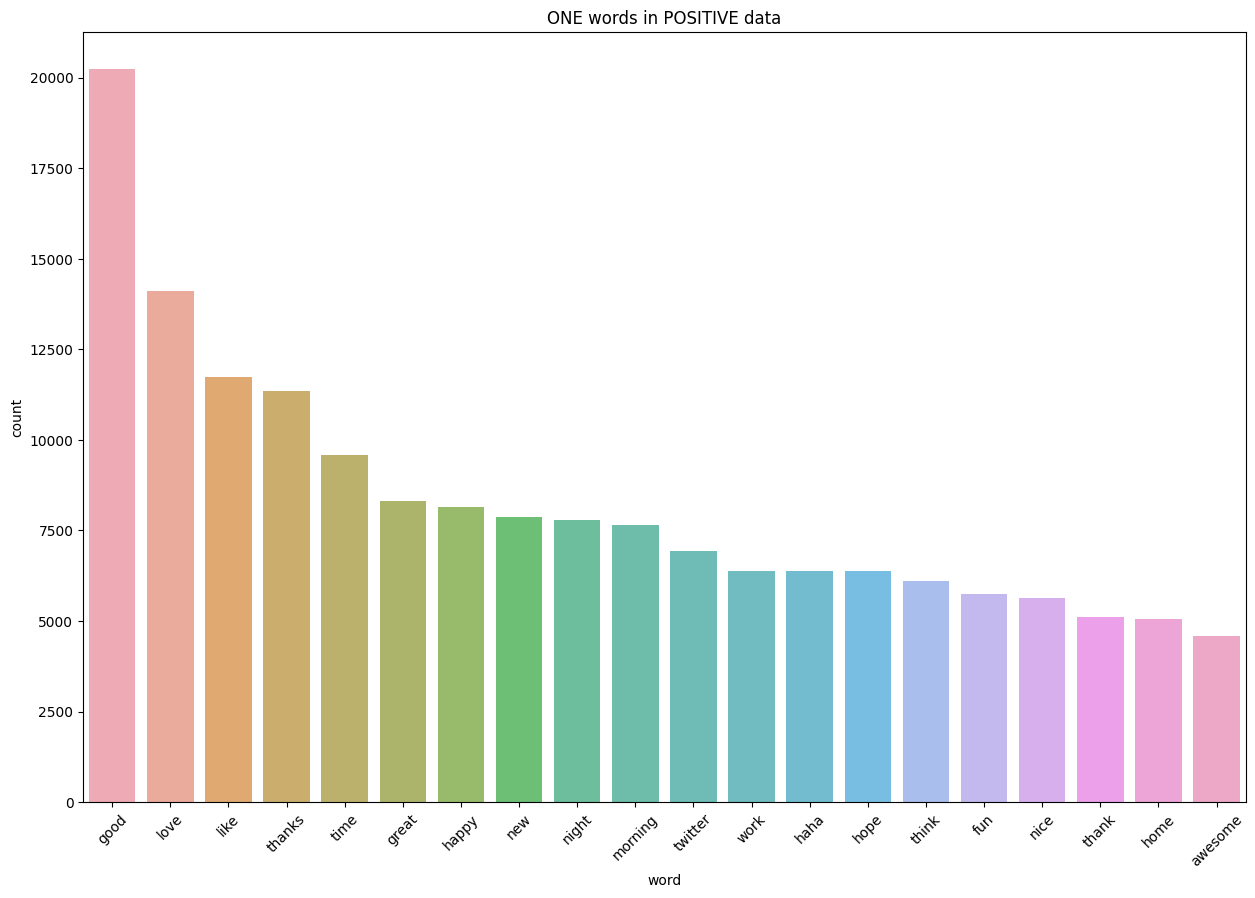

In [35]:
# One words in positive data
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20],
            y = count_corpus["count"][:20],
           alpha=0.8)
plt.title('ONE words in POSITIVE data')
plt.xticks(rotation=45)
plt.show()

In [36]:
def get_count(df):
    dic = {}
    for i in df:
        for j in i.split():
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1    
            
    #dic = dict(sorted(dic.items() , key = lambda x:x[1],reverse=True))
    return(dic)
count_corpus = get_count(negative_list)

In [37]:
count_corpus = pd.DataFrame({"word":list(count_corpus.keys()),
                             "count":list(count_corpus.values())})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

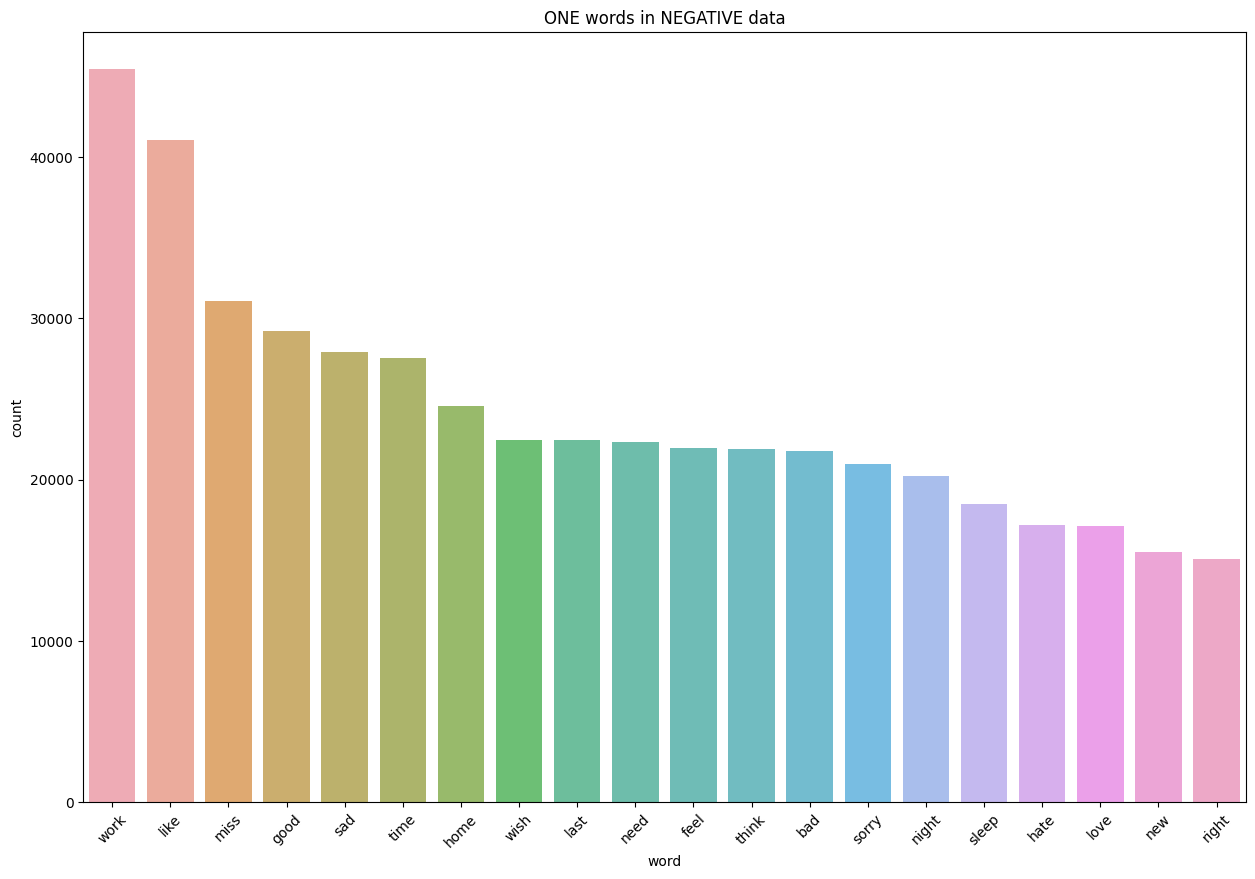

In [38]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20],
            y = count_corpus["count"][:20],
            alpha=0.8)
plt.xticks(rotation=45)
plt.title('ONE words in NEGATIVE data')
plt.show()

## Model Fitting

## TF-IDF for Sentiment Analysis

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(df['liststring'])
y = df['sentiment']

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vector,
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify = y)

**A function to display Training & Testing Metrices**

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

def metrics(y_train,y_train_pred,y_test,y_test_pred):
    print("TRAINING accuracy = ",round(accuracy_score(y_train,y_train_pred),2)*100)
    ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize = 'all')
    
    print(classification_report(y_train,y_train_pred))
    plt.show()

# Testing Accuracy
    print("TESTING accuracy = ",round(accuracy_score(y_test,y_test_pred),2)*100)
    
    ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred,normalize = 'all')
    print(classification_report(y_test,y_test_pred))
    plt.show()

**Insights**
- Using **F1-score weighted** by class imbalance can help improve the model's performance on the minority class.
- This score takes into account the precision and recall for each class, giving *more weight to the **minority class*** to help assess the model's performance in a more balanced way.

**Example of the F1-score weighted by class imbalance**
   - f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

### 1.Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
from lime.lime_text import LimeTextExplainer

# Initialize the LIME explainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

# Select a random instance index from the test set
idx = np.random.randint(0, X_test.shape[0])

# Convert the sparse matrix to a dense array and select the instance
instance = X_test[idx].toarray().flatten()

# Convert the instance back to a string
instance_str = " ".join([str(word) for word in instance])

# Generate an explanation for the selected instance
explanation = explainer.explain_instance(instance_str, lr.predict_proba, num_features=10)

# Display the explanation
explanation.show_in_notebook(text=True)

In [43]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=list(set(y)))  # Adjust class names if needed
idx = np.random.randint(0, X_test.shape[0])
instance = X_test[idx].toarray().flatten()
instance_str = " ".join([str(word) for word in instance])
explanation = explainer.explain_instance(instance_str, lr.predict_proba, num_features=10)
explanation.show_in_notebook(text=True)

MemoryError: Unable to allocate 28.4 GiB for an array with shape (5000,) and data type <U1525104

TRAINING accuracy =  85.0
              precision    recall  f1-score   support

           0       0.86      0.96      0.91    535997
           1       0.78      0.51      0.62    166546

    accuracy                           0.85    702543
   macro avg       0.82      0.73      0.76    702543
weighted avg       0.84      0.85      0.84    702543



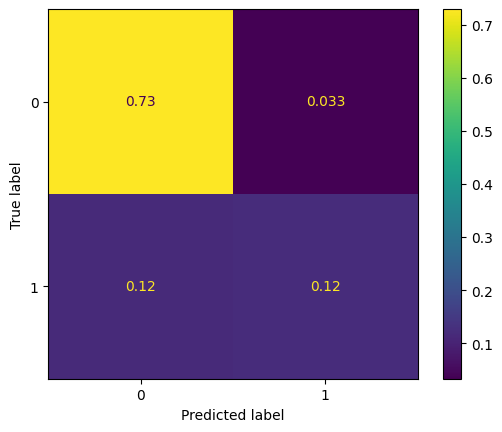

TESTING accuracy =  83.0
              precision    recall  f1-score   support

           0       0.85      0.95      0.89    263999
           1       0.72      0.45      0.56     82030

    accuracy                           0.83    346029
   macro avg       0.79      0.70      0.73    346029
weighted avg       0.82      0.83      0.81    346029



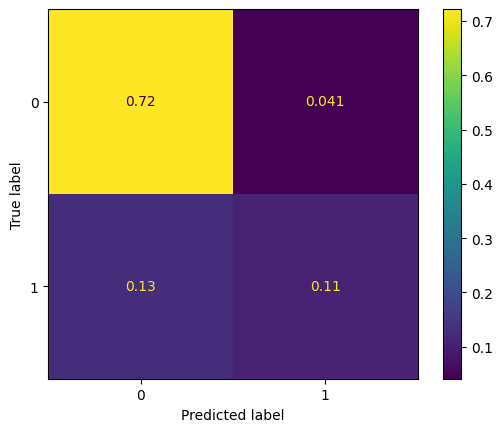

In [44]:
# Predict the sentiment for the train set
y_train_pred = lr.predict(X_train)

# Predict the sentiment for the test set
y_test_pred = lr.predict(X_test)

metrics(y_train,y_train_pred,y_test,y_test_pred)

**Note**
- Due to an issue with the `classification_report` function not recognizing the average parameter, we'll calculate the `F1-score weighted` by class imbalance *manually* using the **precision_recall_fscore_support** function.

**Use this in *def* function above**
#### Testing Accuracy
    from sklearn.metrics import precision_recall_fscore_support
    print("TESTING accuracy = ", round(accuracy_score(y_test, y_test_pred), 2) * 100)

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize='all')
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score weighted:", fscore)
    plt.show()

In [45]:
# Calculate AUC-ROC score for the train set
y_train_prob = lr.predict_proba(X_train)[:, 1]
train_auc_roc = roc_auc_score(y_train, y_train_prob)

print(f"Train AUC-ROC Score: {train_auc_roc}")

Train AUC-ROC Score: 0.8875162773802464


In [46]:
# Calculate AUC-ROC score for the test set
y_test_prob = lr.predict_proba(X_test)[:, 1]
test_auc_roc = roc_auc_score(y_test, y_test_prob)

print(f"Test AUC-ROC Score: {test_auc_roc}")

Test AUC-ROC Score: 0.8572106420548732


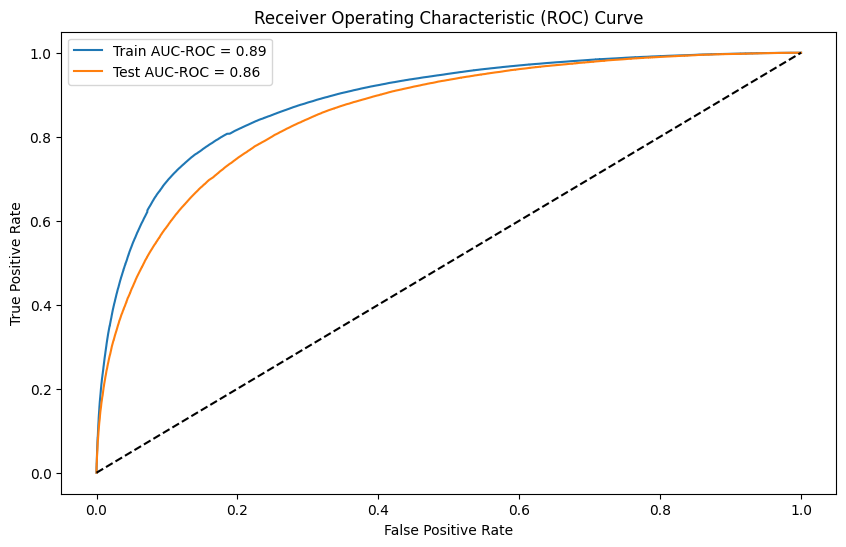

In [47]:
# Plotting ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC-ROC = {train_auc_roc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC-ROC = {test_auc_roc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

**Insights**
- *Train AUC-ROC Score = **0.8831***, which indicates that the model performs well in distinguishing between positive and negative sentiment in the training dataset.
    - A score of `1.0` would indicate a *perfect classifier*, while a score of `0.5` would indicate a classifier that performs no better than random.

- *The Test AUC-ROC Score = **0.8562***, which is slightly **lower than the Train AUC-ROC Score** but still indicates `good performance` of the model on unseen data. This suggests that the model generalizes well and is *not overfitting* to the training data.

**Precision, Recall, and F1-Score:**
- The model performs better for the majority class `(class 0)` compared to the minority class `(class 1)` for both datasets. This is evident from the higher precision, recall, and f1-score for class 0 compared to class 1.

### 2.Multinomial NB

TRAINING accuracy =  80.0
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    535997
           1       0.99      0.16      0.27    166546

    accuracy                           0.80    702543
   macro avg       0.89      0.58      0.58    702543
weighted avg       0.84      0.80      0.74    702543



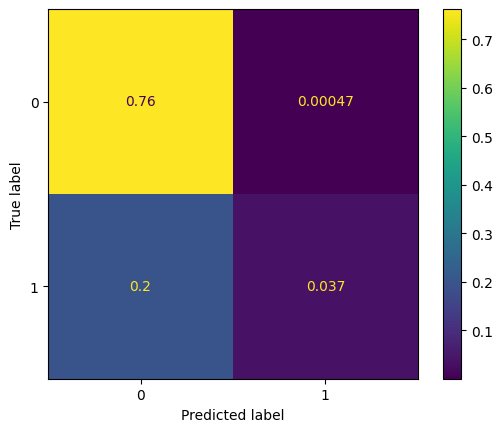

TESTING accuracy =  78.0
              precision    recall  f1-score   support

           0       0.78      1.00      0.87    263999
           1       0.88      0.08      0.15     82030

    accuracy                           0.78    346029
   macro avg       0.83      0.54      0.51    346029
weighted avg       0.80      0.78      0.70    346029



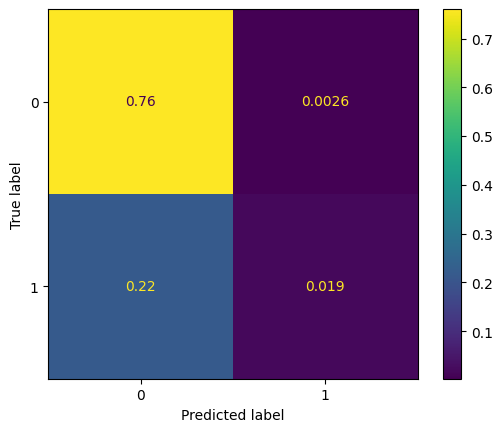

In [48]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train,y_train)
y_train_pred = NB.predict(X_train)
y_test_pred = NB.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

In [49]:
# Calculate AUC-ROC score for the train set
y_train_prob = NB.predict_proba(X_train)[:, 1]
train_auc_roc = roc_auc_score(y_train, y_train_prob)

print(f"Train AUC-ROC Score: {train_auc_roc}")

Train AUC-ROC Score: 0.8753637929142203


In [50]:
# Calculate AUC-ROC score for the test set
y_test_prob = NB.predict_proba(X_test)[:, 1]
test_auc_roc = roc_auc_score(y_test, y_test_prob)

print(f"Test AUC-ROC Score: {test_auc_roc}")

Test AUC-ROC Score: 0.8104221939050646


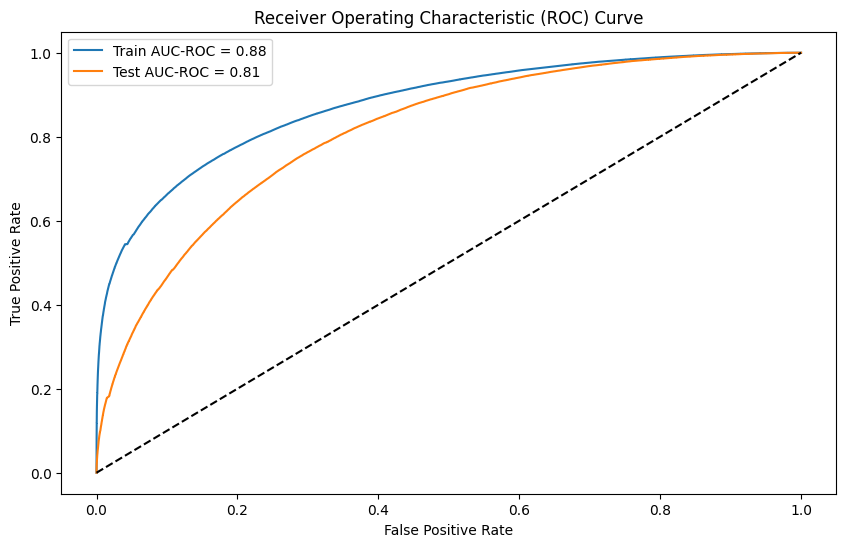

In [51]:
# Plotting ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC-ROC = {train_auc_roc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC-ROC = {test_auc_roc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### 3.Linear SVC

- `CalibratedClassifierCV` is a class in scikit-learn used to calibrate the probabilities of a classifier.
- It can be used to *improve* the calibration of predicted probabilities, particularly for classifiers like SVM or Random Forest that do not inherently provide well-calibrated probabilities.

TRAINING accuracy =  89.0
              precision    recall  f1-score   support

           0       0.90      0.97      0.93    535997
           1       0.88      0.64      0.74    166546

    accuracy                           0.89    702543
   macro avg       0.89      0.81      0.84    702543
weighted avg       0.89      0.89      0.89    702543



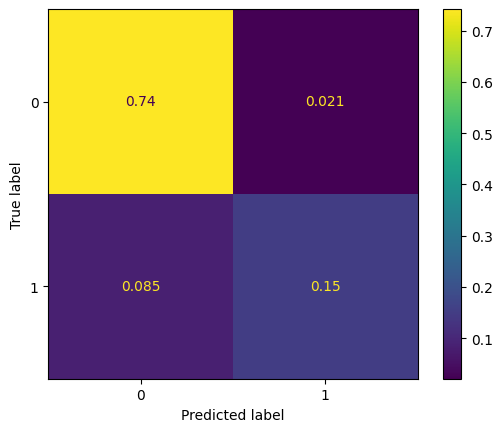

TESTING accuracy =  83.0
              precision    recall  f1-score   support

           0       0.85      0.95      0.89    263999
           1       0.72      0.44      0.55     82030

    accuracy                           0.83    346029
   macro avg       0.78      0.69      0.72    346029
weighted avg       0.82      0.83      0.81    346029



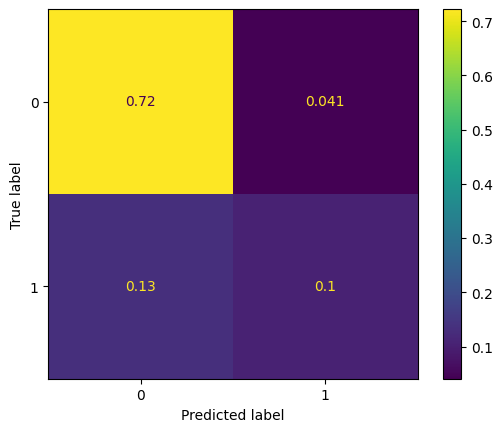

In [52]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC()

# Initialize the CalibratedClassifierCV with the base classifier and the calibration method
calibrated_svc = CalibratedClassifierCV(svc, method='sigmoid', cv=3)

# Fit the calibrated classifier
calibrated_svc.fit(X_train, y_train)

# Predictions on training and testing datasets
y_train_pred = calibrated_svc.predict(X_train)
y_test_pred = calibrated_svc.predict(X_test)

metrics(y_train,y_train_pred,y_test,y_test_pred)

In [53]:
# Calculate AUC-ROC score for the TRAIN set
y_train_pred_proba = calibrated_svc.predict_proba(X_train)[:,1]
train_auc_roc = roc_auc_score(y_train, y_train_pred_proba)
print(f'Training AUC-ROC Score: {train_auc_roc}')

Training AUC-ROC Score: 0.936519052639332


In [54]:
# Calculate AUC-ROC score for the TEST set
y_test_pred_proba = calibrated_svc.predict_proba(X_test)[:,1]
test_auc_roc = roc_auc_score(y_test, y_test_pred_proba)
print(f'Testing AUC-ROC Score: {test_auc_roc}')

Testing AUC-ROC Score: 0.8533357082094939


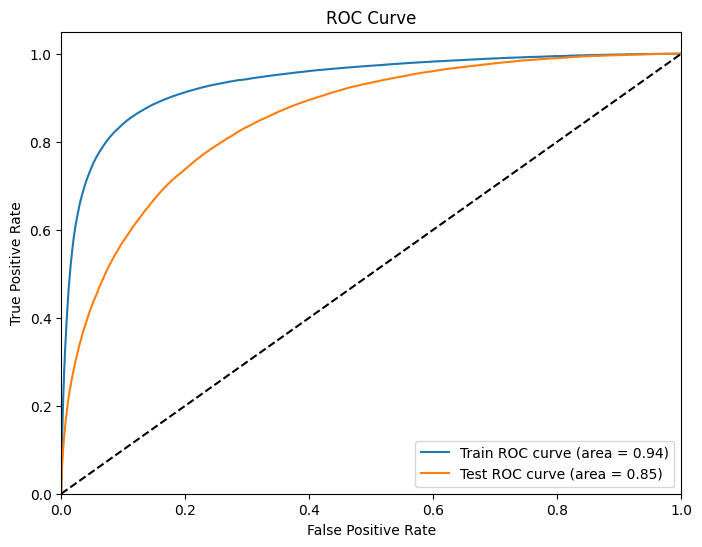

In [55]:
# Plotting ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % train_auc_roc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % test_auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Insights**
- The model shows a potential risk of **overfitting**, as the training score is significantly higher than the testing score. This indicates that the model may have learned the training data too well and may not generalize as effectively to new, unseen data.
- The testing score is still relatively **high**, suggesting that the model is performing well overall and is capable of making accurate predictions on new data.

### LinearDiscriminantAnalysis (LDA) classifier
   - Used for dimensionality reduction and classification.
   - LDA is primarily used for modeling differences in groups in a dataset.